# Used Car Market Analysis in Morocco for Data-Driven Decision Support

### Instructions to Run the Code

1. **Upload the Dataset**  
   Please upload the file **`cars_dataframe.csv`** to your Colab session.

2. **Upload Pretrained Models (Optional but Recommended)**  
   To save time, you can upload the following pretrained model files:
   - `best_lightgbm_model.pkl`
   - `best_catboost_model.pkl`
   - `best_xgb_model.pkl`
   - `best_random_forest_model.pkl`

   These models will be used directly for predictions without retraining.

3. **Run the Code**  
   Once the required files are uploaded, you can proceed to run the notebook cells.


## Section 0: Package Installation

In [238]:
!pip install catboost category_encoders

## Section 1: Imports

In [239]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from category_encoders import TargetEncoder
import ast
import time
import warnings
import os
import joblib

## Section 2: Data Loading and Initial Cleaning

In [240]:
try:
    df = pd.read_csv("cars_dataframe.csv")
    df2 = df
except FileNotFoundError:
    raise FileNotFoundError("The file 'cars_dataframe.csv' was not found in the working directory.")

df = df[df['Price'].notna()]
df = df[df['Brand'].notna() & df['Model'].notna()].reset_index(drop=True)
print(f"Initial data shape: {df.shape}")

Initial data shape: (76412, 15)


### Section 2.1: Data Overview

In [241]:
def data_overview(df):
    print("\n--- Data Overview ---")
    print("Columns and Data Types:")
    print(df.dtypes)
    print("\nFirst 5 Rows:")
    print(df.head().to_string())
    print("\nSummary Statistics for Numerical Columns:")
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    if len(numerical_cols) > 0:
        print(df[numerical_cols].describe())
    else:
        print("No numerical columns found.")


data_overview(df)


--- Data Overview ---
Columns and Data Types:
Brand               object
Model               object
Year                object
Condition           object
Mileage             object
Gearbox             object
Fiscal Power        object
Fuel                object
Equipment           object
Number of Doors    float64
Origin              object
First Owner         object
Location            object
Sector              object
Price              float64
dtype: object

First 5 Rows:
        Brand            Model  Year  Condition            Mileage    Gearbox Fiscal Power    Fuel                                                                                                                                                                                                                                             Equipment  Number of Doors               Origin First Owner    Location       Sector     Price
0  Volkswagen             Polo  1997       Good  200 000 - 249 999     Manual         8 C

### Section 2.2: Null Value Analysis

In [242]:
def null_value_analysis(df):
    print("\n--- Null Value Analysis ---")
    null_counts = df.isna().sum()
    null_percentages = (df.isna().sum() / len(df)) * 100
    null_summary = pd.DataFrame({'Null Count': null_counts, 'Null Percentage (%)': null_percentages})
    print(null_summary)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=null_summary.index, y=null_summary['Null Percentage (%)'])
    plt.title('Percentage of Null Values per Column', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Null Percentage (%)', fontsize=12)
    plt.tight_layout()
    plt.close()

null_value_analysis(df)


--- Null Value Analysis ---
                 Null Count  Null Percentage (%)
Brand                     0             0.000000
Model                     0             0.000000
Year                      0             0.000000
Condition              2173             2.843794
Mileage                   0             0.000000
Gearbox                   0             0.000000
Fiscal Power            213             0.278752
Fuel                      0             0.000000
Equipment                 0             0.000000
Number of Doors        7448             9.747160
Origin                 8456            11.066325
First Owner            9485            12.412972
Location                  0             0.000000
Sector                  176             0.230330
Price                     0             0.000000


## Section 3: Data Discovery

### Section 3.1: Data Overview

In [243]:
def data_discovery_overview(df):
    print("\n--- Data Discovery: Data Overview ---")
    print("Columns and Data Types:")
    print(df.dtypes)
    print("\nFirst 5 Rows:")
    print(df.head().to_string())
    print("\nSummary Statistics for Numerical Columns:")
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    if len(numerical_cols) > 0:
        print(df[numerical_cols].describe())
    else:
        print("No numerical columns found.")

data_discovery_overview(df)


--- Data Discovery: Data Overview ---
Columns and Data Types:
Brand               object
Model               object
Year                object
Condition           object
Mileage             object
Gearbox             object
Fiscal Power        object
Fuel                object
Equipment           object
Number of Doors    float64
Origin              object
First Owner         object
Location            object
Sector              object
Price              float64
dtype: object

First 5 Rows:
        Brand            Model  Year  Condition            Mileage    Gearbox Fiscal Power    Fuel                                                                                                                                                                                                                                             Equipment  Number of Doors               Origin First Owner    Location       Sector     Price
0  Volkswagen             Polo  1997       Good  200 000 - 249 999     Ma

### Section 3.2: Average Selling Price

In [244]:
print("\n--- Data Discovery: Average Selling Price ---")
if 'Price' in df.columns:
    avg_price = df['Price'].mean()
    print(f"Average Selling Price (MAD): {avg_price:,.2f}")
else:
    print("Error: 'Price' column not found.")


--- Data Discovery: Average Selling Price ---
Average Selling Price (MAD): 498,018.10


### Section 3.3: Top Car Selling Cities


--- Data Discovery: Top Car Selling Cities ---
Top 5 Car Selling Cities:
Location
Casablanca    20628
Tanger         5324
Marrakech      5202
Rabat          5064
Agadir         4170
Name: count, dtype: int64


<ipython-input-245-7f3b1d34bfe6>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cities.values, y=top_cities.index, palette='Greens_r')


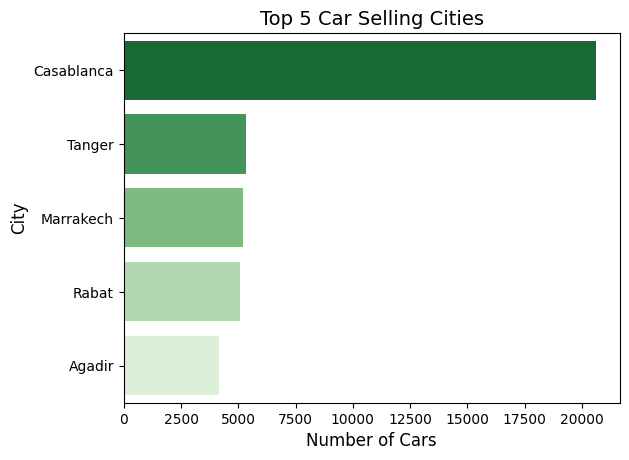

In [245]:
print("\n--- Data Discovery: Top Car Selling Cities ---")
if 'Location' in df.columns:
    top_cities = df['Location'].value_counts().head(5)
    print("Top 5 Car Selling Cities:")
    print(top_cities)
    plt.figure()
    sns.barplot(x=top_cities.values, y=top_cities.index, palette='Greens_r')
    plt.title('Top 5 Car Selling Cities', fontsize=14)
    plt.xlabel('Number of Cars', fontsize=12)
    plt.ylabel('City', fontsize=12)
    plt.show()
else:
    print("Error: 'Location' column not found.")

### Section 3.4: Most-Selling Car Brands


--- Data Discovery: Most-Selling Car Brands ---
Most-Selling Car Brands (Top 10):
Brand
Renault          9433
Volkswagen       9132
Peugeot          7064
Dacia            6354
Mercedes-Benz    5426
Fiat             4785
Hyundai          4076
Ford             3951
Citroen          3293
Audi             2413
Name: count, dtype: int64


<ipython-input-246-0c0dfccc90cc>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_brands.values, y=top_brands.index, palette='Greens_r')


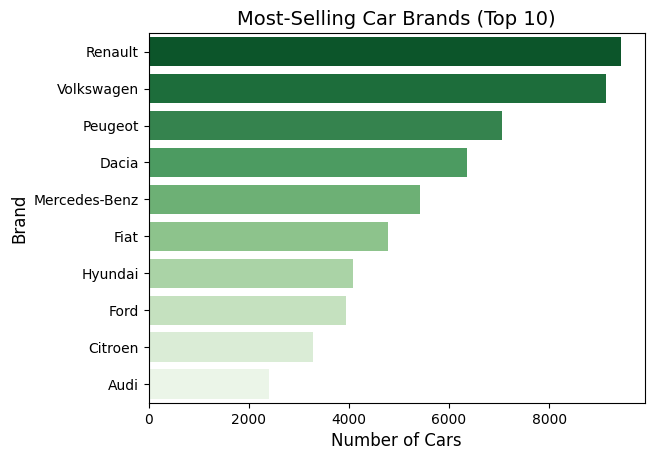

In [246]:
print("\n--- Data Discovery: Most-Selling Car Brands ---")
if 'Brand' in df.columns:
    top_brands = df['Brand'].value_counts().head(10)
    print("Most-Selling Car Brands (Top 10):")
    print(top_brands)
    plt.figure()
    sns.barplot(x=top_brands.values, y=top_brands.index, palette='Greens_r')
    plt.title('Most-Selling Car Brands (Top 10)', fontsize=14)
    plt.xlabel('Number of Cars', fontsize=12)
    plt.ylabel('Brand', fontsize=12)
    plt.show()
else:
    print("Error: 'Brand' column not found.")

### Section 3.5: Car Origins Overview


--- Data Discovery: Car Origins Overview ---
Car Origins Overview (Percentage):
Origin
WW in Morocco                  73.665313
Customs-cleared car            20.348461
Imported New                    5.188651
Car not yet customs-cleared     0.797575
Name: proportion, dtype: float64


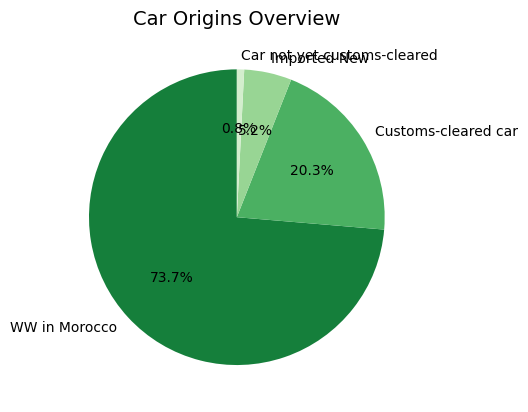

In [247]:
print("\n--- Data Discovery: Car Origins Overview ---")
if 'Origin' in df.columns:
    origin_counts = df['Origin'].value_counts(normalize=True) * 100
    print("Car Origins Overview (Percentage):")
    print(origin_counts)
    plt.figure()
    plt.pie(origin_counts, labels=origin_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Greens_r', len(origin_counts)))
    plt.title('Car Origins Overview', fontsize=14)
    plt.show()
else:
    print("Error: 'Origin' column not found.")

### Section 3.6: Carburetor Types in Listed Cars


--- Data Discovery: Carburetor Types in Listed Cars ---
Carburetor Types in Listed Cars (Percentage):
Fuel
Diesel        79.679893
Petrol        19.112181
Hybrid         0.868973
Electrique     0.278752
LPG            0.060200
Name: proportion, dtype: float64


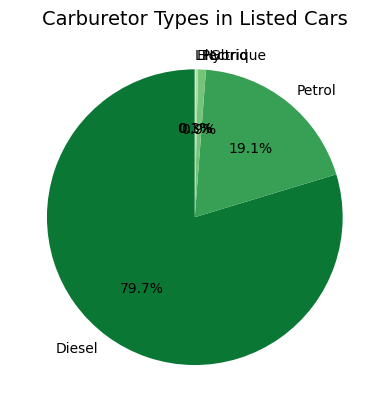

In [248]:
print("\n--- Data Discovery: Carburetor Types in Listed Cars ---")
if 'Fuel' in df.columns:
    fuel_counts = df['Fuel'].value_counts(normalize=True) * 100
    print("Carburetor Types in Listed Cars (Percentage):")
    print(fuel_counts)
    plt.figure()
    plt.pie(fuel_counts, labels=fuel_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Greens_r', len(fuel_counts)))
    plt.title('Carburetor Types in Listed Cars', fontsize=14)
    plt.show()
else:
    print("Error: 'Fuel' column not found.")

### Section 3.7: Most Types of Cars Selling in Each City


--- Data Discovery: Most Types of Cars Selling in Each City ---
Most Common Car Model in Each Top City:
        Location Model  Count
144       Agadir  Clio    192
662   Casablanca  Clio    675
1322   Marrakech  Clio    209
1828       Rabat  Clio    179
2286      Tanger  Clio    226


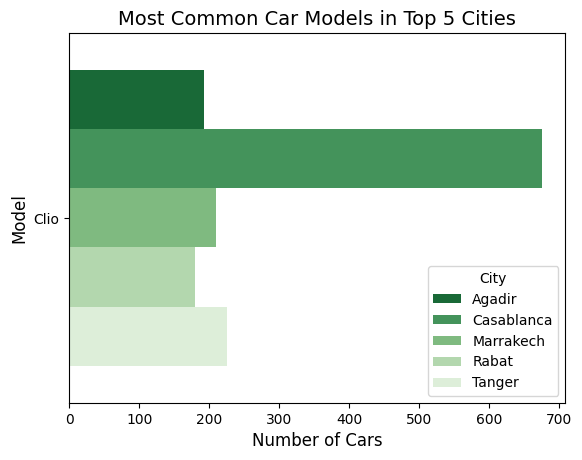

In [249]:
print("\n--- Data Discovery: Most Types of Cars Selling in Each City ---")
if 'Location' in df.columns and 'Model' in df.columns:
    top_cities = df['Location'].value_counts().head(5).index
    city_model_counts = df[df['Location'].isin(top_cities)].groupby(['Location', 'Model']).size().reset_index(name='Count')
    top_models_per_city = city_model_counts.loc[city_model_counts.groupby('Location')['Count'].idxmax()]
    print("Most Common Car Model in Each Top City:")
    print(top_models_per_city)
    plt.figure()
    sns.barplot(x='Count', y='Model', hue='Location', data=top_models_per_city, palette='Greens_r')
    plt.title('Most Common Car Models in Top 5 Cities', fontsize=14)
    plt.xlabel('Number of Cars', fontsize=12)
    plt.ylabel('Model', fontsize=12)
    plt.legend(title='City')
    plt.show()
else:
    print("Error: 'Location' or 'Model' column not found.")

### Section 3.8: Additional KPIs

In [250]:
print("\n--- Data Discovery: Additional KPIs ---")
total_cars = len(df)
print(f"Total Number of Cars: {total_cars:,}")
price_range = df['Price'].agg(['min', 'max']) if 'Price' in df.columns else {'min': None, 'max': None}
print(f"Price Range (MAD): {price_range['min']:,} to {price_range['max']:,}")
if 'Brand' in df.columns:
    brand_diversity = df['Brand'].nunique()
    print(f"Number of Unique Brands: {brand_diversity}")
else:
    print("Error: 'Brand' column not found for brand diversity.")


--- Data Discovery: Additional KPIs ---
Total Number of Cars: 76,412
Price Range (MAD): 1.0 to 1,600,000,000.0
Number of Unique Brands: 73


## Section 4: Feature Preprocessing

In [251]:

# Standardize and encode 'First Owner'
df['First Owner'] = df['First Owner'].astype(str).str.strip().str.title().replace('Nan', None)
df['First Owner'] = df['First Owner'].fillna('No')
le = LabelEncoder()
df['First Owner'] = le.fit_transform(df['First Owner'])

# Encode binary categorical columns
binary_cols = ['Gearbox', 'Fuel', 'Condition']
label_encoders = {}
for col in binary_cols:
    df[col] = df[col].astype(str).str.strip().str.title()
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = dict(zip(le.classes_, le.transform(le.classes_)))

# Clean 'Fiscal Power'
def clean_fiscal_power(val):
    if pd.isna(val):
        return None
    val = str(val).strip()
    if "Plus de" in val:
        return 42
    if "CV" in val:
        val = val.replace(" CV", "")
    try:
        return float(val)
    except:
        return None
df['Fiscal Power'] = df['Fiscal Power'].apply(clean_fiscal_power)

# Clean 'Mileage'
def mileage_to_avg(val):
    if pd.isna(val):
        return None
    val = str(val).replace(" km", "").strip()
    try:
        if "-" in val:
            low, high = map(int, val.replace(" ", "").split("-"))
            return (low + high) / 2
        return float(val.replace(" ", ""))
    except:
        return None
df['Mileage'] = df['Mileage'].apply(mileage_to_avg)

# Convert 'Year' to numeric and rename to 'Model_Year'
print("Columns before Year processing:", df.columns.tolist())
if 'Year' not in df.columns:
    year_variants = ['year', 'YEAR', 'Model Year', 'Manufacturing Year']
    for variant in year_variants:
        if variant in df.columns:
            print(f"Found {variant} column, renaming to 'Model_Year'")
            df['Model_Year'] = df[variant]
            df.drop(columns=[variant], inplace=True)
            break
    else:
        raise KeyError("No 'Year' column or variant found in DataFrame")
else:
    df['Model_Year'] = df['Year']
    df.drop(columns=['Year'], inplace=True)

# Convert Model_Year to numeric
df['Model_Year'] = pd.to_numeric(df['Model_Year'], errors='coerce')
# Log invalid Model_Year values
invalid_years = df[df['Model_Year'].isna()]
if not invalid_years.empty:
    print(f"Found {len(invalid_years)} rows with invalid Model_Year values:")
    print(invalid_years[['Model_Year', 'Price', 'Brand', 'Model']].head())
# Drop rows with missing Model_Year
df = df.dropna(subset=['Model_Year']).reset_index(drop=True)
# Convert to int64
df['Model_Year'] = df['Model_Year'].astype('int64')

# Filter out future years
CURRENT_YEAR = 2025
df = df[df['Model_Year'] <= CURRENT_YEAR].copy()


doors_mode = df['Number of Doors'].mode()[0]
df['Number of Doors'] = df['Number of Doors'].fillna(doors_mode)

# Standardize text columns
df['Brand'] = df['Brand'].str.strip().str.title()
df['Model'] = df['Model'].str.strip().str.title()
df['Origin'] = df['Origin'].fillna("Unknown").str.strip().str.title()
df['Location'] = df['Location'].str.strip().str.title()
df['Sector'] = df['Sector'].fillna("Unknown").str.strip().str.title()

# Parse 'Equipment'
def parse_equipment(e):
    try:
        return ast.literal_eval(e) if pd.notna(e) else []
    except:
        return []
df['Equipment'] = df['Equipment'].apply(parse_equipment)

print(f"Shape after initial preprocessing: {df.shape}")
print(f"Model_Year dtype: {df['Model_Year'].dtype}")
print(f"Model_Year sample: {df['Model_Year'].head().tolist()}")
print(f"Columns after preprocessing: {df.columns.tolist()}")
assert df['Model_Year'].dtype == 'int64', f"Model_Year column is not int64, found {df['Model_Year'].dtype}"
assert df['Model_Year'].notna().all(), "Model_Year column contains NaNs"
assert 'Model_Year' in df.columns, "Model_Year column missing from DataFrame"
assert 'Year' not in df.columns, "Year column still present in DataFrame"

Columns before Year processing: ['Brand', 'Model', 'Year', 'Condition', 'Mileage', 'Gearbox', 'Fiscal Power', 'Fuel', 'Equipment', 'Number of Doors', 'Origin', 'First Owner', 'Location', 'Sector', 'Price']
Found 187 rows with invalid Model_Year values:
      Model_Year     Price          Brand    Model
132          NaN  130000.0        Peugeot      404
208          NaN   45000.0  Mercedes-Benz      190
794          NaN   30000.0           Seat  Cordoba
823          NaN  175000.0  Mercedes-Benz      280
2378         NaN   17000.0        Renault       12
Shape after initial preprocessing: (76225, 15)
Model_Year dtype: int64
Model_Year sample: [1997, 2012, 2004, 2009, 2013]
Columns after preprocessing: ['Brand', 'Model', 'Condition', 'Mileage', 'Gearbox', 'Fiscal Power', 'Fuel', 'Equipment', 'Number of Doors', 'Origin', 'First Owner', 'Location', 'Sector', 'Price', 'Model_Year']


### Section 4.1: Data Type Validation

In [252]:
def data_type_validation(df):
    print("\n--- Data Type Validation ---")
    print("Columns and Data Types after Preprocessing:")
    dtypes_df = df.dtypes.to_frame('Data Type')
    print(dtypes_df)
    object_cols = dtypes_df[dtypes_df['Data Type'] == 'object'].index
    if len(object_cols) > 0:
        print(f"Warning: Found object-type columns that may need conversion: {object_cols.tolist()}")
data_type_validation(df)


--- Data Type Validation ---
Columns and Data Types after Preprocessing:
                Data Type
Brand              object
Model              object
Condition           int64
Mileage           float64
Gearbox             int64
Fiscal Power      float64
Fuel                int64
Equipment          object
Number of Doors   float64
Origin             object
First Owner         int64
Location           object
Sector             object
Price             float64
Model_Year          int64


## Section 5: Feature Engineering

In [253]:
# Use dynamic CURRENT_YEAR
df['Car_Age'] = CURRENT_YEAR - df['Model_Year']
df['Car_Age'] = df['Car_Age'].clip(lower=0)  # Prevent negative ages
if (df['Car_Age'] < 0).any():
    print(f"Warning: {sum(df['Car_Age'] < 0)} negative Car_Age values found before clipping")

# Mileage_per_Year
df['Mileage_per_Year'] = df['Mileage'] / df['Car_Age']
# Log cases where division by zero or NaN occurs
invalid_mpy = np.isinf(df['Mileage_per_Year']) | df['Mileage_per_Year'].isna()
if invalid_mpy.any():
    print(f"Warning: {sum(invalid_mpy)} rows with invalid Mileage_per_Year (inf/NaN)")
# Replace infinities/NaNs with median Mileage_per_Year
median_mpy = df['Mileage_per_Year'][~invalid_mpy].median()
df['Mileage_per_Year'] = np.where(invalid_mpy, median_mpy, df['Mileage_per_Year'])

# Define equipment and luxury features
equipment_cols = [
    'ABS', 'Air Conditioning', 'Airbags', 'Alloy Wheels', 'CD/MP3/Bluetooth',
    'Central Locking', 'Cruise Control', 'ESP', 'Electric Windows', 'Leather Seats',
    'Navigation System/GPS', 'Onboard Computer', 'Parking Sensors', 'Rear Camera',
    'Speed Limiter', 'Sunroof'
]
luxury_features = {
    'Leather Seats': 2, 'Navigation System/GPS': 2, 'Sunroof': 2,
    'Cruise Control': 1.5, 'Rear Camera': 1.5, 'Parking Sensors': 1.5, 'Alloy Wheels': 1
}

# Polynomial features
poly_features = ['Model_Year', 'Brand_te', 'Model_te']

print("New features added: Car_Age, Mileage_per_Year")
print(df[['Car_Age', 'Mileage_per_Year']].describe())

New features added: Car_Age, Mileage_per_Year
            Car_Age  Mileage_per_Year
count  76225.000000      76225.000000
mean      13.254090      13079.233851
std        8.504074       9477.961706
min        1.000000         56.806818
25%        7.000000       7499.500000
50%       11.000000      13124.937500
75%       18.000000      17857.071429
max       44.000000     474999.500000


## Section 6: Encoding and Binarization

In [254]:
# Target encoding
brand_te = TargetEncoder(cols=['Brand'])
model_te = TargetEncoder(cols=['Model'])
df['Brand_te'] = brand_te.fit_transform(df[['Brand']], df['Price'])
df['Model_te'] = model_te.fit_transform(df[['Model']], df['Price'])
df.drop(columns=['Brand', 'Model'], inplace=True)

# Frequency encoding with rare category handling
for col in ['Location', 'Sector']:
    freq_map = df[col].value_counts(normalize=True)
    rare_categories = freq_map[freq_map < 0.01].index
    df[col] = df[col].where(~df[col].isin(rare_categories), 'Other')
    freq_map = df[col].value_counts(normalize=True)
    df[col + '_freq'] = df[col].map(freq_map)
    df.drop(columns=col, inplace=True)

# Encode Origin
le_origin = LabelEncoder()
df['Origin'] = le_origin.fit_transform(df['Origin'])

# Binarize Equipment
mlb = MultiLabelBinarizer()
equipment_df = pd.DataFrame(mlb.fit_transform(df['Equipment']),
                            columns=mlb.classes_,
                            index=df.index)
equipment_df = equipment_df.astype('int64')
df = pd.concat([df.drop(columns='Equipment'), equipment_df], axis=1)

# Ensure all equipment columns exist
missing_equipment = [col for col in equipment_cols if col not in df.columns]
if missing_equipment:
    print(f"Warning: Missing equipment columns {missing_equipment}, setting to 0")
    for col in missing_equipment:
        df[col] = 0

# Compute Equipment_Count and Luxury_Score
df['Equipment_Count'] = df[equipment_cols].sum(axis=1)
df['Luxury_Score'] = df[list(luxury_features.keys())].mul(list(luxury_features.values())).sum(axis=1)

# Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_data = poly.fit_transform(df[poly_features])
poly_columns = poly.get_feature_names_out(poly_features)
poly_df = pd.DataFrame(poly_data, columns=[f"poly_{col}" for col in poly_columns], index=df.index, dtype='float64')
df = pd.concat([df, poly_df], axis=1)

# Verify column types and duplicates
print(f"Shape after encoding and binarization: {df.shape}")
print("Column dtypes after encoding:")
print(df.dtypes)
duplicate_columns = df.columns[df.columns.duplicated()].tolist()
if duplicate_columns:
    print(f"Warning: Duplicate columns found: {duplicate_columns}")
    df = df.loc[:, ~df.columns.duplicated()]  # Remove duplicates

Shape after encoding and binarization: (76225, 40)
Column dtypes after encoding:
Condition                     int64
Mileage                     float64
Gearbox                       int64
Fiscal Power                float64
Fuel                          int64
Number of Doors             float64
Origin                        int64
First Owner                   int64
Price                       float64
Model_Year                    int64
Car_Age                       int64
Mileage_per_Year            float64
Brand_te                    float64
Model_te                    float64
Location_freq               float64
Sector_freq                 float64
ABS                           int64
Air Conditioning              int64
Airbags                       int64
Alloy Wheels                  int64
CD/MP3/Bluetooth              int64
Central Locking               int64
Cruise Control                int64
ESP                           int64
Electric Windows              int64
Leather Seats      

### Section 6.1: Encoded Data Summary

In [255]:
def encoded_data_summary(df):
    print("\n--- Encoded Data Summary ---")
    print("First 5 Rows after Encoding:")
    print(df.head().to_string())
    # Focus on encoded columns
    encoded_cols = ['Brand_te', 'Model_te', 'Location_freq', 'Sector_freq', 'Origin'] + equipment_cols + ['Equipment_Count', 'Luxury_Score']
    encoded_cols = [col for col in encoded_cols if col in df.columns]
    print("\nSummary Statistics for Encoded Columns:")
    print(df[encoded_cols].describe())
    # Check for non-numeric columns
    non_numeric_cols = df.select_dtypes(exclude=['int64', 'float64']).columns
    if len(non_numeric_cols) > 0:
        print(f"Warning: Non-numeric columns remaining: {non_numeric_cols.tolist()}")
encoded_data_summary(df)


--- Encoded Data Summary ---
First 5 Rows after Encoding:
   Condition   Mileage  Gearbox  Fiscal Power  Fuel  Number of Doors  Origin  First Owner     Price  Model_Year  Car_Age  Mileage_per_Year       Brand_te      Model_te  Location_freq  Sector_freq  ABS  Air Conditioning  Airbags  Alloy Wheels  CD/MP3/Bluetooth  Central Locking  Cruise Control  ESP  Electric Windows  Leather Seats  Navigation System/GPS  Onboard Computer  Parking Sensors  Rear Camera  Speed Limiter  Sunroof  Equipment_Count  Luxury_Score  poly_Model_Year  poly_Brand_te  poly_Model_te  poly_Model_Year Brand_te  poly_Model_Year Model_te  poly_Brand_te Model_te
0          4  224999.5        1           8.0     0              5.0       3            0   27000.0        1997       28       8035.696429  672937.660268  1.248826e+06       0.019902     0.061725    0                 0        0             0                 1                0               0    0                 0              1                      0        

## Section 7: Outlier Removal and Imputation

In [256]:
# IQR-based outlier removal for Price
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
pre_outlier_shape = df.shape
df = df[df['Price'].between(lower_bound, upper_bound)].copy()
print(f"Removed {pre_outlier_shape[0] - df.shape[0]} rows due to Price outliers")

# Clip Mileage outliers
Q1_mileage = df['Mileage'].quantile(0.25)
Q3_mileage = df['Mileage'].quantile(0.75)
IQR_mileage = Q3_mileage - Q1_mileage
lower_clip = max(0, Q1_mileage - 1.5 * IQR_mileage)  # Ensure non-negative
upper_clip = Q3_mileage + 1.5 * IQR_mileage
df['Mileage'] = df['Mileage'].clip(lower=lower_clip, upper=upper_clip)

# Missing value indicator
df['Fiscal_Power_missing'] = df['Fiscal Power'].isna().astype(int)

# KNN imputation
numeric_cols = [
    'Fiscal Power', 'Mileage', 'Car_Age', 'Mileage_per_Year', 'Equipment_Count',
    'Luxury_Score', 'Model_Year', 'Brand_te', 'Model_te', 'Location_freq', 'Sector_freq'
] + [f"poly_{col}" for col in poly_columns]
imputer = KNNImputer(n_neighbors=5)
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

print(f"Shape after outlier removal and imputation: {df.shape}")

Removed 4965 rows due to Price outliers
Shape after outlier removal and imputation: (71260, 41)


## Section 8: Feature Selection and Scaling

In [257]:
is_log_transformed = False
if df['Price'].skew() > 1:
    df['Price'] = np.log1p(df['Price'])
    is_log_transformed = True
    print("Price log-transformed due to skewness")

# Select features
selected_features = [
    'Model_Year', 'Mileage', 'Car_Age', 'Mileage_per_Year', 'Equipment_Count', 'Luxury_Score',
    'Brand_te', 'Model_te', 'Location_freq', 'Sector_freq', 'Origin', 'Fiscal_Power_missing'
] + [f"poly_{col}" for col in poly_columns]

# Prepare X and y
X = df[selected_features].copy()
y = df['Price']

# Verify all columns are numeric
non_numeric_cols = X.select_dtypes(exclude=['int64', 'float64']).columns
if non_numeric_cols.any():
    print(f"Warning: Non-numeric columns found: {non_numeric_cols.tolist()}")
    for col in non_numeric_cols:
        X[col] = pd.to_numeric(X[col], errors='coerce')
        if X[col].isna().any():
            print(f"Filling NaNs in {col} with mean")
            X[col] = X[col].fillna(X[col].mean())

# Define numeric columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
if not numeric_cols:
    raise ValueError("No numeric columns found for scaling")

# Scale numeric features
scaler = StandardScaler()
X.loc[:, numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Verify X
print(f"Selected features: {selected_features}")
print(f"X shape: {X.shape}")
print("X dtypes:")
print(X.dtypes)
print("Missing values per column:")
print(X.isna().sum())
assert X.isna().sum().sum() == 0, f"NaNs found in X: {X.isna().sum()}"

Selected features: ['Model_Year', 'Mileage', 'Car_Age', 'Mileage_per_Year', 'Equipment_Count', 'Luxury_Score', 'Brand_te', 'Model_te', 'Location_freq', 'Sector_freq', 'Origin', 'Fiscal_Power_missing', 'poly_Model_Year', 'poly_Brand_te', 'poly_Model_te', 'poly_Model_Year Brand_te', 'poly_Model_Year Model_te', 'poly_Brand_te Model_te']
X shape: (71260, 18)
X dtypes:
Model_Year                  float64
Mileage                     float64
Car_Age                     float64
Mileage_per_Year            float64
Equipment_Count             float64
Luxury_Score                float64
Brand_te                    float64
Model_te                    float64
Location_freq               float64
Sector_freq                 float64
Origin                      float64
Fiscal_Power_missing        float64
poly_Model_Year             float64
poly_Brand_te               float64
poly_Model_te               float64
poly_Model_Year Brand_te    float64
poly_Model_Year Model_te    float64
poly_Brand_te Model_t

<ipython-input-257-abf333247c50>:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.21841928  0.62711299  0.62711299 ...  0.62711299  0.62711299
  0.62711299]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[:, numeric_cols] = scaler.fit_transform(X[numeric_cols])
<ipython-input-257-abf333247c50>:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.05115653 -0.05115653 -0.05115653 ... -0.05115653 -0.05115653
 -0.05115653]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[:, numeric_cols] = scaler.fit_transform(X[numeric_cols])


## Section 9: Train-Test Split and Hyperparameter Tuning

In [258]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Verify no NaNs or non-numeric columns
assert X_train.isna().sum().sum() == 0, f"NaNs found in X_train: {X_train.isna().sum()}"
assert X_test.isna().sum().sum() == 0, f"NaNs found in X_test: {X_test.isna().sum()}"
non_numeric_train = X_train.select_dtypes(exclude=['int64', 'float64']).columns
if non_numeric_train.any():
    raise ValueError(f"Non-numeric columns in X_train: {non_numeric_train.tolist()}")

cat_features_indices = []
print(f"Categorical feature indices for CatBoost: {cat_features_indices}")

Training set shape: (57008, 18)
Test set shape: (14252, 18)
Categorical feature indices for CatBoost: []


## Section 10: Models Training with Hyperparameter Optimization




### Section 10.1: XGBOOST

In [259]:
model_path = 'best_xgb_model.pkl'

if os.path.exists(model_path):
    print("Loading saved XGBoost model...")
    best_xgb = joblib.load(model_path)
    print("Model loaded successfully!")
else:
    print("No saved model found. Tuning XGBoost hyperparameters...")
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 6, 10],
        'min_child_weight': [1, 5],
        'subsample': [0.7, 1.0],
        'colsample_bytree': [0.7, 1.0],
        'reg_alpha': [0, 0.1],
        'reg_lambda': [1.0, 10.0]
    }
    xgb = XGBRegressor(random_state=42, enable_categorical=False)
    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1,
        error_score='raise'
    )
    try:
        grid_search.fit(X_train, y_train)
        print("Best parameters:", grid_search.best_params_)
        best_xgb = grid_search.best_estimator_
        # Save the trained model
        joblib.dump(best_xgb, model_path)
        print(f"Model saved to {model_path}")
    except Exception as e:
        print(f"Grid search failed: {e}")
        raise


Loading saved XGBoost model...
Model loaded successfully!


### Section 10.2: Ridge Regression

In [260]:
print("\n=== Ridge Regression ===")
model_path = 'best_ridge_model.pkl'
if os.path.exists(model_path):
    print("Loading saved Ridge Regression model...")
    best_ridge = joblib.load(model_path)
    print("Model loaded successfully!")
else:
    print("No saved model found. Tuning Ridge Regression hyperparameters...")
    param_grid = {
        'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
    }
    ridge = Ridge(random_state=42)
    grid_search = GridSearchCV(
        estimator=ridge,
        param_grid=param_grid,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1,
        error_score='raise'
    )
    try:
        grid_search.fit(X_train, y_train)
        print("Best parameters:", grid_search.best_params_)
        best_ridge = grid_search.best_estimator_
        joblib.dump(best_ridge, model_path)
        print(f"Model saved to {model_path}")
    except Exception as e:
        print(f"Grid search failed: {e}")
        raise



=== Ridge Regression ===
Loading saved Ridge Regression model...
Model loaded successfully!


### Section 10.3: CatBoost

In [261]:
# CatBoost
print("\n=== CatBoost ===")
model_path = 'best_catboost_model.pkl'
if os.path.exists(model_path):
    print("Loading saved CatBoost model...")
    best_cat = joblib.load(model_path)
    print("Model loaded successfully!")
else:
    print("No saved model found. Tuning CatBoost hyperparameters...")
    param_grid = {
        'iterations': [100, 200],
        'depth': [4, 6, 10],
        'learning_rate': [0.01, 0.1],
        'l2_leaf_reg': [1, 3, 10]
    }
    cat = CatBoostRegressor(cat_features=cat_features_indices, verbose=0, random_state=42)
    grid_search = GridSearchCV(
        estimator=cat,
        param_grid=param_grid,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1,
        error_score='raise'
    )
    try:
        grid_search.fit(X_train, y_train)
        print("Best parameters:", grid_search.best_params_)
        best_cat = grid_search.best_estimator_
        joblib.dump(best_cat, model_path)
        print(f"Model saved to {model_path}")
    except Exception as e:
        print(f"Grid search failed: {e}")
        raise


=== CatBoost ===
Loading saved CatBoost model...
Model loaded successfully!


### Section 10.4: LightGBM

In [262]:
# LightGBM
print("\n=== LightGBM ===")
model_path = 'best_lightgbm_model.pkl'
if os.path.exists(model_path):
    print("Loading saved LightGBM model...")
    best_lgbm = joblib.load(model_path)
    print("Model loaded successfully!")
else:
    print("No saved model found. Tuning LightGBM hyperparameters...")
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 6, 10],
        'num_leaves': [31, 50, 100]
    }
    lgbm = LGBMRegressor(random_state=42)
    grid_search = GridSearchCV(
        estimator=lgbm,
        param_grid=param_grid,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1,
        error_score='raise'
    )
    try:
        grid_search.fit(X_train, y_train)
        print("Best parameters:", grid_search.best_params_)
        best_lgbm = grid_search.best_estimator_
        joblib.dump(best_lgbm, model_path)
        print(f"Model saved to {model_path}")
    except Exception as e:
        print(f"Grid search failed: {e}")
        raise


=== LightGBM ===
Loading saved LightGBM model...
Model loaded successfully!


## Section 11: Cross-Validation

In [263]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    if not mask.any():
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def within_tolerance_accuracy(y_true, y_pred, tolerance=10000):
    return np.mean(np.abs(y_true - y_pred) <= tolerance) * 100

models = {
    'Ridge Regression': best_ridge,
    'XGBoost': best_xgb,
    'CatBoost': best_cat,
    'LightGBM': best_lgbm
}

results = {
    'Model': [], 'Train RMSE': [], 'Test RMSE': [], 'Train MAE': [], 'Test MAE': [],
    'Train MAPE (%)': [], 'Test MAPE (%)': [], 'Train Within ±10,000 MAD (%)': [],
    'Test Within ±10,000 MAD (%)': [], 'Train R²': [], 'Test R²': [],
    'Train Loss (MSE)': [], 'Test Loss (MSE)': [], 'Training Time (s)': []
}
predictions = {'Actual': y_test}

is_log_transformed = False

for name, model in models.items():
    print(f"\nTraining tuned {name}...")
    start_time = time.time()
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    predictions[name] = y_test_pred

    if is_log_transformed:
        y_train_pred = np.expm1(y_train_pred)
        y_test_pred = np.expm1(y_test_pred)
        y_train_eval = np.expm1(y_train)
        y_test_eval = np.expm1(y_test)
    else:
        y_train_eval = y_train
        y_test_eval = y_test

    train_mse = mean_squared_error(y_train_eval, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train_eval, y_train_pred)
    train_mape = mean_absolute_percentage_error(y_train_eval, y_train_pred)
    train_within = within_tolerance_accuracy(y_train_eval, y_train_pred)
    train_r2 = r2_score(y_train_eval, y_train_pred)

    test_mse = mean_squared_error(y_test_eval, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test_eval, y_test_pred)
    test_mape = mean_absolute_percentage_error(y_test_eval, y_test_pred)
    test_within = within_tolerance_accuracy(y_test_eval, y_test_pred)
    test_r2 = r2_score(y_test_eval, y_test_pred)

    training_time = time.time() - start_time

    results['Model'].append(name)
    results['Train RMSE'].append(train_rmse)
    results['Test RMSE'].append(test_rmse)
    results['Train MAE'].append(train_mae)
    results['Test MAE'].append(test_mae)
    results['Train MAPE (%)'].append(train_mape)
    results['Test MAPE (%)'].append(test_mape)
    results['Train Within ±10,000 MAD (%)'].append(train_within)
    results['Test Within ±10,000 MAD (%)'].append(test_within)
    results['Train R²'].append(train_r2)
    results['Test R²'].append(test_r2)
    results['Train Loss (MSE)'].append(train_mse)
    results['Test Loss (MSE)'].append(test_mse)
    results['Training Time (s)'].append(training_time)

    print(f"  Training time: {training_time:.2f} seconds")
    print(f"  Test RMSE: {test_rmse:.4f}")
    print(f"  Test R²: {test_r2:.4f}")

results_df = pd.DataFrame(results)
print("\nTuned Models Train-Test Split Results:")
print(results_df.sort_values(by='Test RMSE').round(4))


Training tuned Ridge Regression...
  Training time: 0.03 seconds
  Test RMSE: 49729.7796
  Test R²: 0.5288

Training tuned XGBoost...
  Training time: 2.73 seconds
  Test RMSE: 24805.9469
  Test R²: 0.8828

Training tuned CatBoost...
  Training time: 11.27 seconds
  Test RMSE: 26706.9247
  Test R²: 0.8641

Training tuned LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1964
[LightGBM] [Info] Number of data points in the train set: 57008, number of used features: 18
[LightGBM] [Info] Start training from score 115391.271243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

## Section 12: Visualization

### Prediction scatter plots

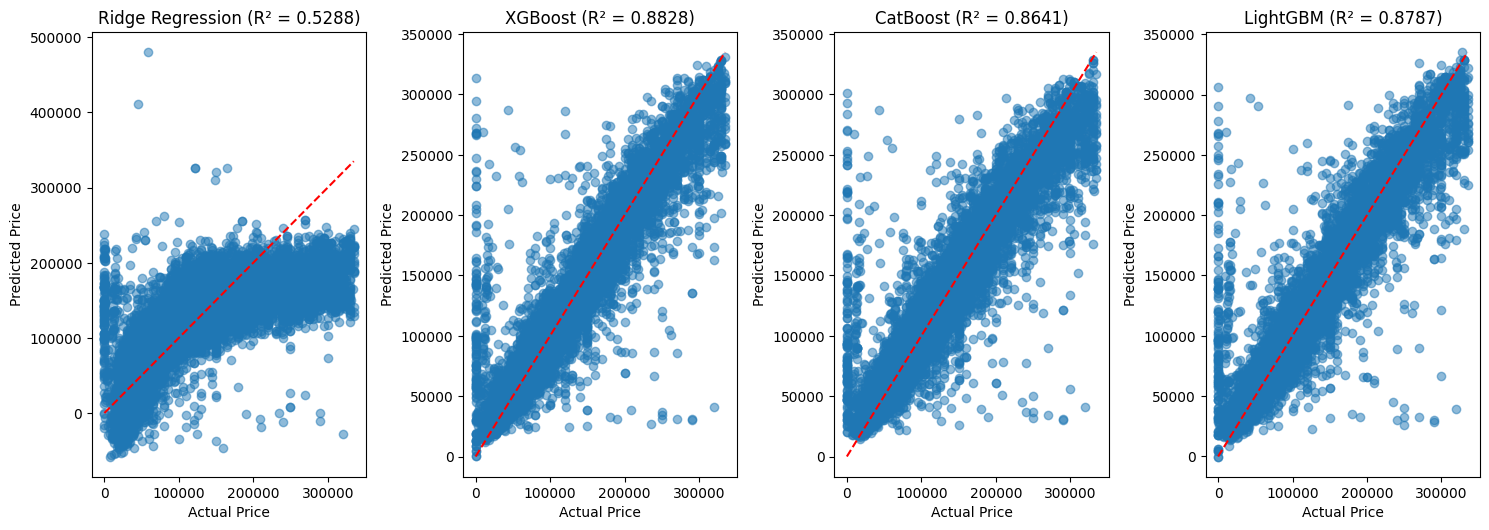

In [264]:
plt.figure(figsize=(15, 10))
for i, model_name in enumerate(models.keys()):
    plt.subplot(2, 4, i+1)
    y_test_plot = np.expm1(y_test) if is_log_transformed else y_test
    y_pred_plot = np.expm1(predictions[model_name]) if is_log_transformed else predictions[model_name]
    plt.scatter(y_test_plot, y_pred_plot, alpha=0.5)
    plt.plot([y_test_plot.min(), y_test_plot.max()], [y_test_plot.min(), y_test_plot.max()], 'r--')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(f'{model_name} (R² = {r2_score(y_test_plot, y_pred_plot):.4f})')
plt.tight_layout()

### Feature importance for tree-based models

### Metrics comparison

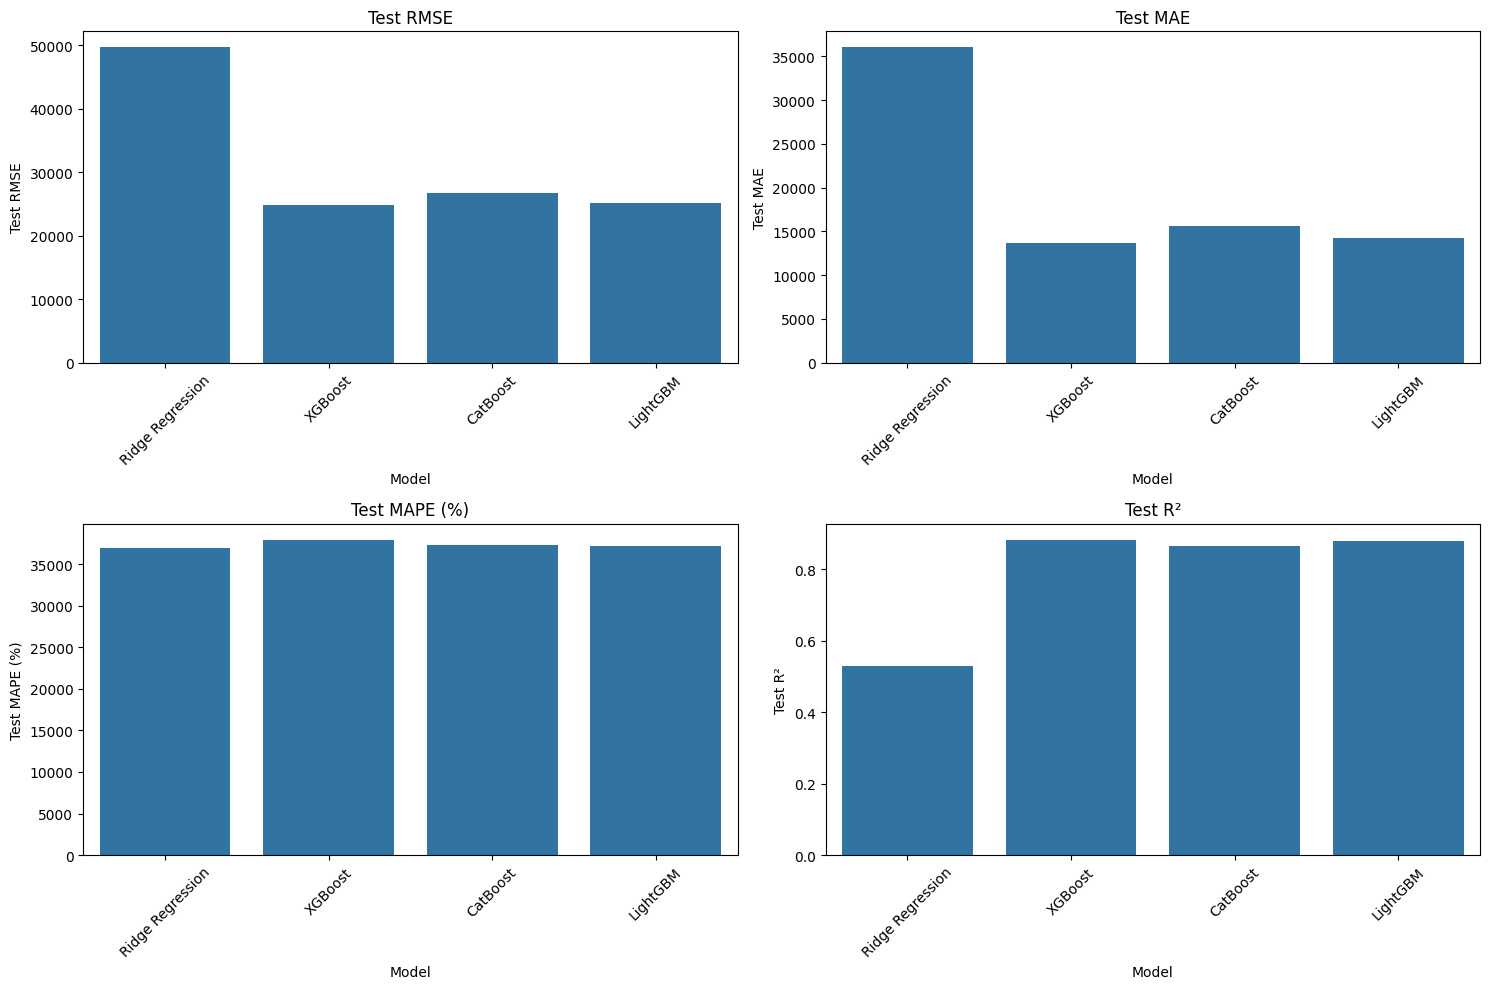

In [265]:
metrics_to_plot = ['Test RMSE', 'Test MAE', 'Test MAPE (%)', 'Test R²']
plt.figure(figsize=(15, 10))
for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 2, i+1)
    sns.barplot(x='Model', y=metric, data=results_df)
    plt.title(metric)
    plt.xticks(rotation=45)
plt.tight_layout()

### Feature importance for tree-based models


Feature Importance for XGBoost:
                     Feature  Importance
0                 Model_Year      0.2329
2                    Car_Age      0.1951
16  poly_Model_Year Model_te      0.1347
12           poly_Model_Year      0.0614
6                   Brand_te      0.0454
13             poly_Brand_te      0.0438
7                   Model_te      0.0437
5               Luxury_Score      0.0436
15  poly_Model_Year Brand_te      0.0421
4            Equipment_Count      0.0400

Feature Importance for CatBoost:
                     Feature  Importance
12           poly_Model_Year     11.9555
13             poly_Brand_te     10.0700
6                   Brand_te      9.9075
15  poly_Model_Year Brand_te      9.8897
0                 Model_Year      8.5949
16  poly_Model_Year Model_te      7.5336
2                    Car_Age      7.5059
14             poly_Model_te      7.4862
7                   Model_te      6.7735
17    poly_Brand_te Model_te      6.0819

Feature Importance for LightGB

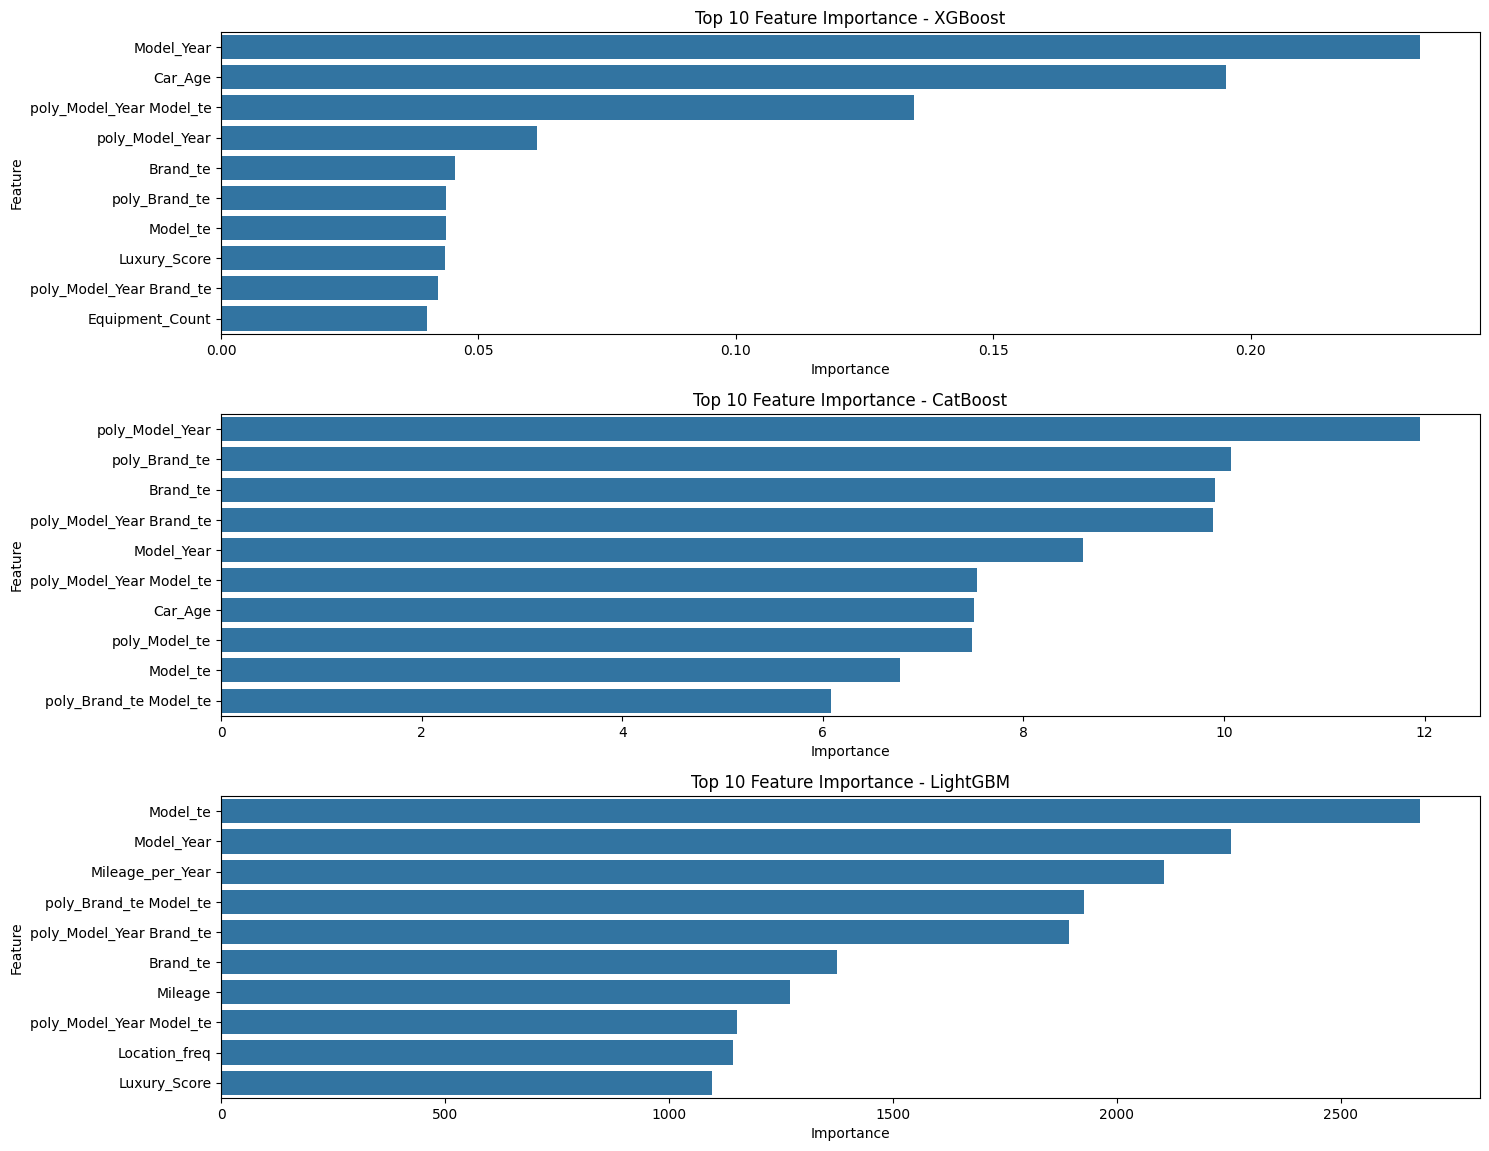

In [266]:
plt.figure(figsize=(15, 15))
plot_count = 0
for name in ['Random Forest', 'XGBoost', 'CatBoost', 'LightGBM']:
    if name in models and hasattr(models[name], 'feature_importances_'):
        try:
            plot_count += 1
            importance = pd.DataFrame({
                'Feature': X.columns,
                'Importance': models[name].feature_importances_
            }).sort_values(by='Importance', ascending=False)

            print(f"\nFeature Importance for {name}:")
            print(importance.head(10).round(4))

            plt.subplot(4, 1, plot_count)
            sns.barplot(x='Importance', y='Feature', data=importance.head(10))
            plt.title(f'Top 10 Feature Importance - {name}')
        except Exception as e:
            print(f"Failed to plot feature importance for {name}: {e}")

plt.tight_layout()

### Residual analysis

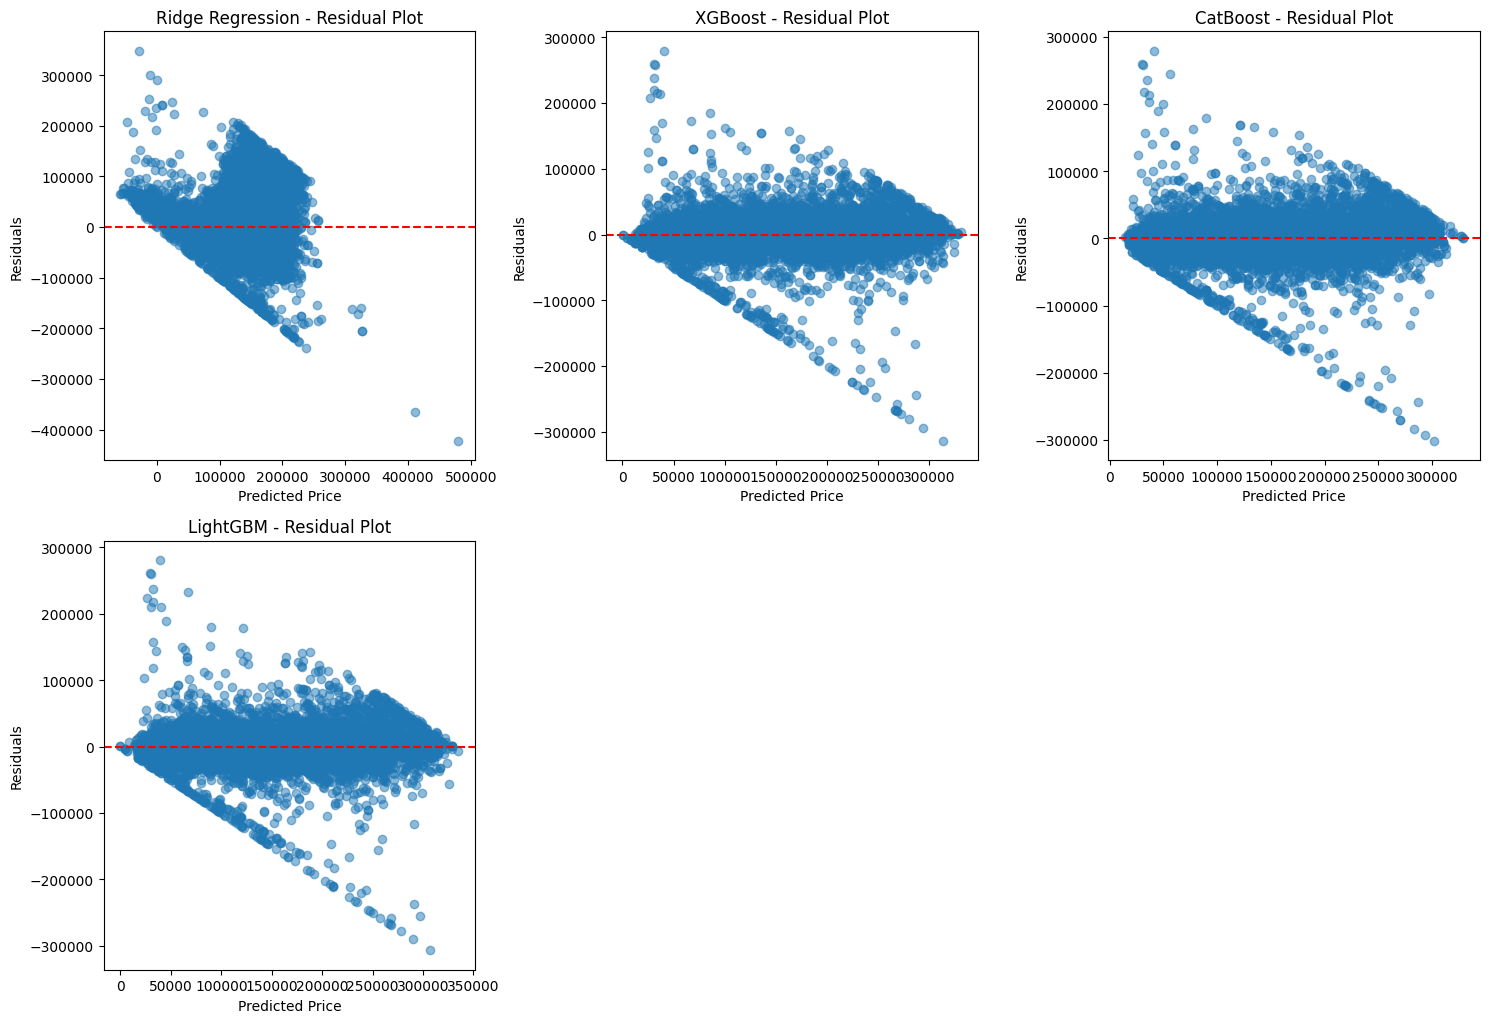

In [267]:
plt.figure(figsize=(15, 15))
for i, model_name in enumerate(models.keys(), 1):
    plt.subplot(3, 3, i)
    y_test_plot = np.expm1(y_test) if is_log_transformed else y_test
    y_pred_plot = np.expm1(predictions[model_name]) if is_log_transformed else predictions[model_name]
    residuals = y_test_plot - y_pred_plot
    plt.scatter(y_pred_plot, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Price')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} - Residual Plot')
plt.tight_layout()